In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sqlite3
import zipfile

# The imports are required in order to process, clean, read, organize, and vizualize the data.
Worked on By Brian Gorbea

In [2]:
# Path to the zip file
zip_file_path = '../../data/im.db.zip'
# Folder to extract the zip file contents
extract_folder = '../../Unzipped_database'

The process here is pulling the databse file, unzipping the file and extracting the file to a local location. The file is then opened and read using SQL commands within python. Python pulls the data and stores it in the a variable called a dataframe for later use.

In [3]:
# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract the contents of the zip file to the extract_folder
    zip_ref.extractall(extract_folder)

In [4]:
db_file_path = f'{extract_folder}/im.db'
conn = sqlite3.connect(db_file_path)
cursor = conn.cursor()

In [5]:
q = """
SELECT primary_title, genres
FROM movie_basics
;"""
movie_genres = pd.read_sql_query(q, conn)

# Start of data pulling and organization
Below the data is being pulled from each file and being stored to a variable for use.

The genre data in the database stored more than one genre per movie. The solution was to seperate the genres and pull the first genre that appears and mark that as the primary genre.

In [6]:
movie_genres['primary_genre'] = movie_genres['genres'].str.split(',').str.get(0)

In [7]:
movie_genres = movie_genres.rename(columns={'primary_title': 'movie'})

In [8]:
movie_budgets_df = pd.read_csv('../../data/tn.movie_budgets.csv.gz', encoding='latin1', index_col=0)

In [9]:
movie_gross_df = pd.read_csv('../../data/bom.movie_gross.csv.gz')

In [10]:
movie_gross_df = movie_gross_df.rename(columns={'title': 'movie'})

In [11]:
Bugets_Gross_df = pd.merge(movie_gross_df, movie_budgets_df, on=['movie'])
#Bugets_Gross_df['profit'] = Bugets_Gross_df['worldwide_gross'] - Bugets_Gross_df['production_budget']

# Cleaning the gross and bugget data
The steps below looks at the columns for world wide gross and production budgets and turn them into readable values that python can use to do calculations. This way we can easily create the profit table to use for the vizualizations.

In [12]:
# Clean the worldwide_gross column
Bugets_Gross_df['worldwide_gross'] = Bugets_Gross_df['worldwide_gross'].str.replace('$', '').str.replace(',', '')

In [13]:
# Convert the column to float
Bugets_Gross_df['worldwide_gross'] = Bugets_Gross_df['worldwide_gross'].astype(float)

In [14]:
# Clean the production_budget column
Bugets_Gross_df['production_budget'] = Bugets_Gross_df['production_budget'].str.replace('$', '').str.replace(',', '')

# Convert the column to float
Bugets_Gross_df['production_budget'] = Bugets_Gross_df['production_budget'].astype(float)

In [15]:
# Calculate the profit column
Bugets_Gross_df['profit'] = Bugets_Gross_df['worldwide_gross'] - Bugets_Gross_df['production_budget']

# Sorting data
The data is being sorted by most profitable to least profitable. One it has been sorted the data grabs the top 10 results from the list. The top ten list is then used for vizualiation later for top ten profitable movies.

In [16]:
profit_sorted= Bugets_Gross_df.sort_values(by='profit', ascending=False)
topTen = profit_sorted.head(10)

In [17]:
topTen_rev = topTen.iloc[::-1].reset_index(drop=True)
topTen_rev['profit'] = topTen_rev['profit']/1000000


# This is the end of the major data collection
The base data has been sorted.

In [18]:
def format_values(value):
    if value >= 1000000000: # Billions
        return f"{value / 1000000000:.1f}B"
    elif value >= 10000000: # Millions
        return f"{value / 1000000:.1f}M"
    elif value <0 and abs(value) >= 1000000: # Negative Millions
        return f"{value / 1000000:.1f}M"
    else:
        return str(value)

In [19]:
def format_values_x(value):
    if value >= 1000000000: # Billions
        return f"{value / 1000000000:.1f}"
    elif value >= 10000000: # Millions
        return f"{value / 1000000:.1f}"
    elif value <0 and abs(value) >= 1000000: # Negative Millions
        return f"{value / 1000000:.1f}"
    else:
        return str(value)

# 1st Vizualization - Top Ten Most Profitable Movies
This vizualization is showing the top ten most profititable movies released. The data here is used to get an understanding on which movies did well and to research what they did to replicate the success.

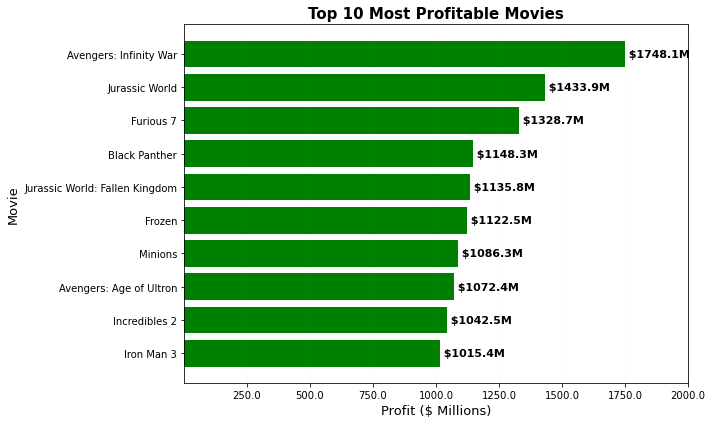

In [20]:
#Plotting
fig, ax = plt.subplots(figsize=(10,6))

ax.barh(topTen_rev['movie'], topTen_rev['profit'], color='green')

#Title and labels
ax.set_title('Top 10 Most Profitable Movies', fontweight='bold', fontsize=15)

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels([format_values_x(x) for x in ax.get_xticks()])

ax.set_xlabel('Profit ($ Millions)', fontsize=13)
ax.set_ylabel('Movie', fontsize=13)
ax.grid(axis='x', linestyle='--', alpha = 0.07)
ax.set_xlim(1, ax.get_xlim()[1])

for index, value in enumerate(topTen_rev['profit']):
    formatted_value = "${:.1f}M".format(value)
    ax.text(value, index, ' ' + str(formatted_value), va='center', fontweight = 'bold', fontsize =11)

plt.tight_layout()
plt.show()

In [21]:
profit_sorted= Bugets_Gross_df.sort_values(by='profit', ascending=False)
bot_Ten = profit_sorted.tail(10)

# 2nd Vizualization - Bottom Ten Least Profitable Movies
This vizualization is showing the bottom ten least profititable movies released. The data here is used to get an understanding how movies didn't do well and to research what to avoid in producing a movie.

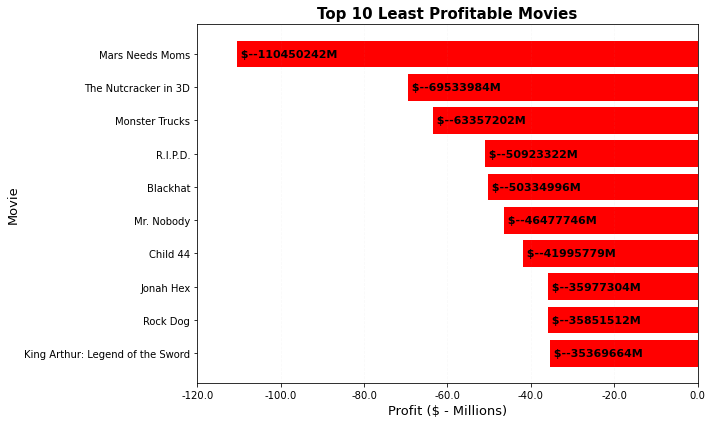

In [22]:
    #Plotting
fig, ax = plt.subplots(figsize=(10,6))
ax.barh(bot_Ten['movie'], bot_Ten['profit'], color='red')

#Title and labels
ax.set_title('Top 10 Least Profitable Movies', fontweight='bold', fontsize=15)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels([format_values_x(x) for x in ax.get_xticks()])
ax.set_xlabel('Profit ($ - Millions)', fontsize=13)
ax.set_ylabel('Movie', fontsize=13)
ax.grid(axis='x', linestyle='--', alpha = 0.07)
#ax.ticklabel_format(style='plain', axis='x', useOffset=False)

for index, value in enumerate(bot_Ten['profit']):
        
        formatted_value = "$-{:.0f}M".format(value)
        ax.text(value, index, ' ' + str(formatted_value), va='center', fontweight = 'bold', fontsize =11)


plt.tight_layout()
plt.show()

In [23]:
profit_ten = profit_sorted[profit_sorted['production_budget'] < 10000000]
profit_ten = profit_ten.head(10)
profit_ten = profit_ten.iloc[::-1].reset_index(drop=True)
profit_ten['profit'] = profit_ten['profit']/1000000

# 3rd Vizualization - Top Ten Profitable Movies with a Buget Undet 10M
The next vizualization is showing the most suscesful movies that have a buget that would better represent the budget of the startup movie company. This data can be used to get a better study on the type of movies in there buget range.

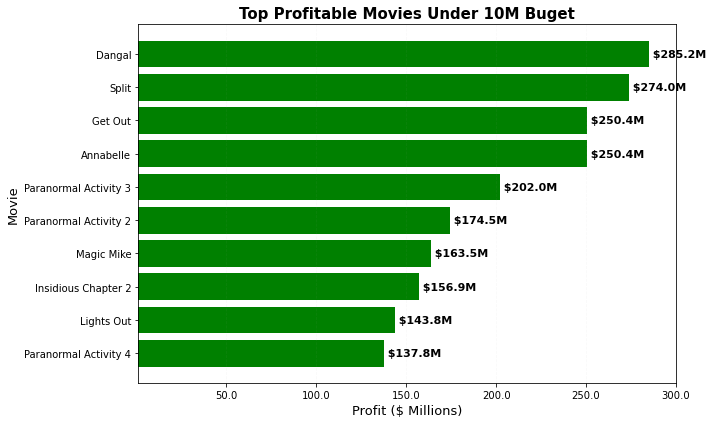

In [24]:
#Plotting
fig, ax = plt.subplots(figsize=(10,6))
ax.barh(profit_ten['movie'], profit_ten['profit'], color='green')

#Title and labels
ax.set_title('Top Profitable Movies Under 10M Buget', fontweight='bold', fontsize=15)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels([format_values_x(x) for x in ax.get_xticks()])
ax.set_xlabel('Profit ($ Millions)', fontsize=13)
ax.set_ylabel('Movie', fontsize=13)
ax.grid(axis='x', linestyle='--', alpha = 0.07)
ax.set_xlim(1, ax.get_xlim()[1])
#ax.ticklabel_format(style='plain', axis='x', useOffset=False)

for index, value in enumerate(profit_ten['profit']):
    
    formatted_value = "${:.1f}M".format(value)
    ax.text(value, index, ' ' + str(formatted_value), va='center', fontweight = 'bold', fontsize =11)
    
    

plt.tight_layout()
plt.show()

# Creating Data
Data is being merged and calculated to represent the average based on the primary genre of a movie.

In [25]:
profgenre = pd.merge(movie_genres, profit_sorted, on=['movie'])

In [26]:
profgenre_grouped = profgenre.groupby('primary_genre').mean()['profit'].sort_values()

# 4th Vizualization - Top  Average Profits by Genre
The vizualization is used to get the average profit based on genre. This data can represent which genres don't do well and what to potentially avoid. Such as making a Western movie may not produce results.

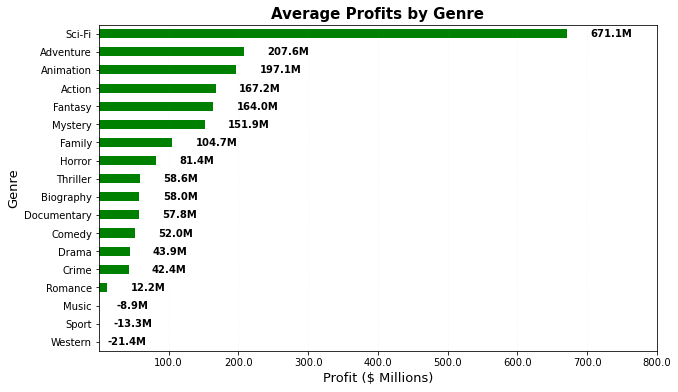

In [29]:
#Plotting
fig, ax = plt.subplots(figsize=(10,6))
profgenre_grouped.plot(kind='barh',color='green', ax=ax)

#Title and labels
ax.set_title('Average Profits by Genre', fontweight='bold', fontsize=15)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels([format_values_x(x) for x in ax.get_xticks()])
ax.set_xlabel('Profit ($ Millions)', fontsize=13)
ax.set_ylabel('Genre', fontsize=13)
ax.grid(axis='x', linestyle='--', alpha = 0.07)
ax.set_xlim(1, ax.get_xlim()[1])


for index, value in enumerate(profgenre_grouped):
    ax.text(value + (0.05 * max(profgenre_grouped)), index,format_values(value), va = 'center', color = 'black', fontweight='bold')

plt.tight_layout
plt.show()